In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

train_data = pd.read_csv('./Train_Test_Splits/Context/train.csv')
test_data = pd.read_csv('./Train_Test_Splits/Context/test.csv')
df = pd.concat([train_data, test_data], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361346 entries, 0 to 104333
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           361346 non-null  int64  
 1   track_id          361346 non-null  object 
 2   hashtag           361346 non-null  object 
 3   created_at        361346 non-null  object 
 4   score             361346 non-null  float64
 5   lang              361346 non-null  object 
 6   tweet_lang        361346 non-null  object 
 7   time_zone         328718 non-null  object 
 8   instrumentalness  361333 non-null  float64
 9   liveness          361333 non-null  float64
 10  speechiness       361332 non-null  float64
 11  danceability      361332 non-null  float64
 12  valence           361330 non-null  float64
 13  loudness          361346 non-null  float64
 14  tempo             361346 non-null  float64
 15  acousticness      361333 non-null  float64
 16  energy            361333 

In [2]:
# 先做缺失值填充
# 一些音乐特性取平均值
lack_columns = ['instrumentalness', 'liveness', 'speechiness', 'danceability', 'valence', 'acousticness', 'energy']
for column in lack_columns:
    df[column] = df[column].fillna(value=df[column].mean())

# 音调和调式、时区可简单取上一条记录的值
df.drop('rating', axis = 1, inplace=True)
df = df.ffill()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361346 entries, 0 to 104333
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           361346 non-null  int64  
 1   track_id          361346 non-null  object 
 2   hashtag           361346 non-null  object 
 3   created_at        361346 non-null  object 
 4   score             361346 non-null  float64
 5   lang              361346 non-null  object 
 6   tweet_lang        361346 non-null  object 
 7   time_zone         361346 non-null  object 
 8   instrumentalness  361346 non-null  float64
 9   liveness          361346 non-null  float64
 10  speechiness       361346 non-null  float64
 11  danceability      361346 non-null  float64
 12  valence           361346 non-null  float64
 13  loudness          361346 non-null  float64
 14  tempo             361346 non-null  float64
 15  acousticness      361346 non-null  float64
 16  energy            361346 

### 探索性数据分析（EDA）
用训练集df完成一些数据分析
#### 单变量分析
* 时区（Time_zone）
 * 语言（Tweet_lang and lang）
 * 调式（Mode）
 * 音调（Key）
 * 推文标签（Hashtag）
 * 音乐情绪（Valence）
 
 ......

In [3]:
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小

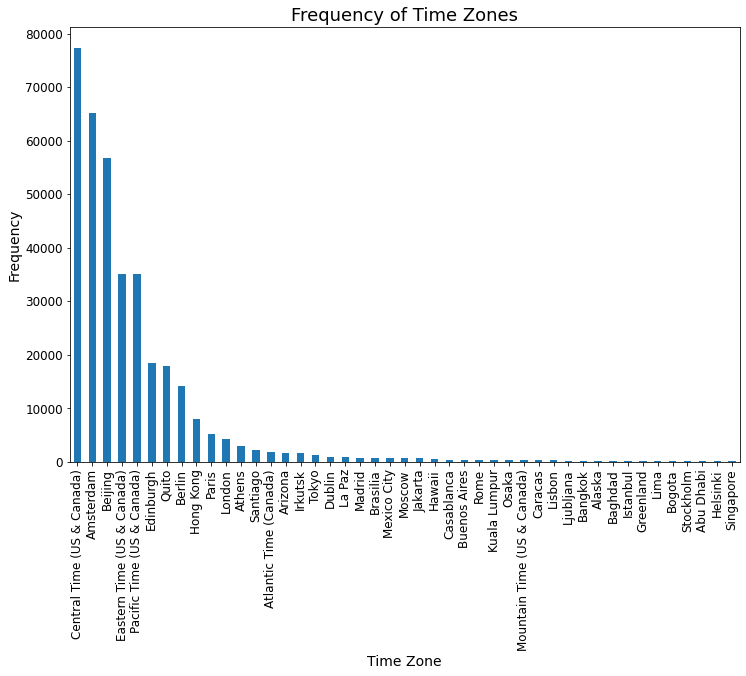

In [4]:
# 时区
time_zone_count = df['time_zone'].value_counts()
time_zone_count = time_zone_count[time_zone_count > 100]
time_zone_count.plot(kind='bar')
plt.xlabel('Time Zone')
plt.ylabel('Frequency')
plt.title('Frequency of Time Zones')
plt.show()

In [5]:
time_zone_view = time_zone_count[time_zone_count > 1000]
time_zone_view

time_zone
Central Time (US & Canada)    77376
Amsterdam                     65110
Beijing                       56730
Eastern Time (US & Canada)    35099
Pacific Time (US & Canada)    35038
Edinburgh                     18546
Quito                         17876
Berlin                        14209
Hong Kong                      7948
Paris                          5284
London                         4272
Athens                         2910
Santiago                       2247
Atlantic Time (Canada)         1768
Arizona                        1747
Irkutsk                        1694
Tokyo                          1220
Name: count, dtype: int64

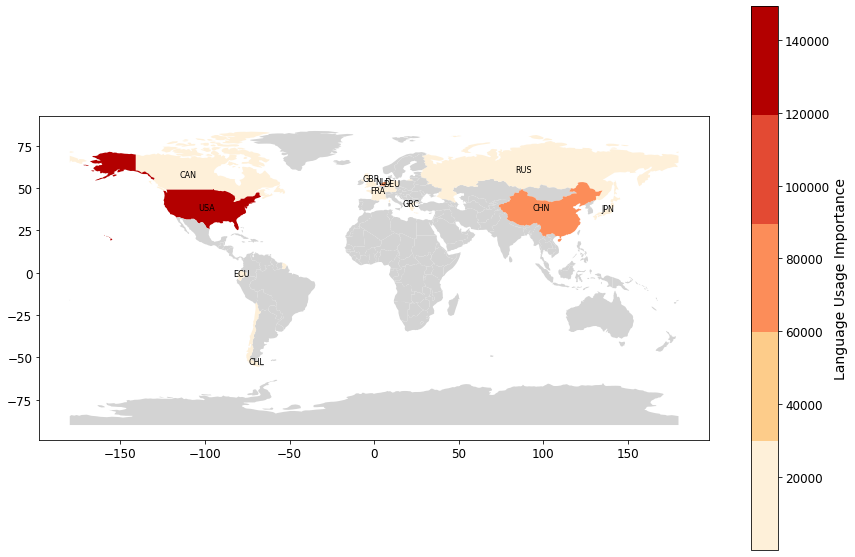

In [6]:
import geopandas as gpd
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

country_importance = {'USA': 77376 + 35099 + 35038 + 1747, 'NLD': 65110, 'CHN': 56730 + 7948, 'ECU': 17876,
                   'GBR': 18546 + 4272, 'DEU':14209, 'FRA':5284, 'GRC':2910, 'CHL':2247, 'CAN':1768, 'RUS':1694, 'JPN':1220 }

# 加载世界地图
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['importance'] = world['iso_a3'].apply(lambda x: country_importance.get(x, 0))


# 定义一个自定义颜色映射
cmap = ListedColormap(['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000'])
# 确保0值以外的数据使用cmap，0值数据使用特定颜色（如灰色）
cmap.set_under('lightgrey')

# 绘制地图，颜色深浅表示重要程度
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(column='importance', ax=ax, legend=True,
           legend_kwds={'label': "Language Usage Importance"},
           cmap=cmap,
           vmin=0.0001)  # 使用颜色映射，深色表示高重要性

# 标注国家名称
for iso_a3, importance in country_importance.items():
    # 找到对应国家
    country = world[world['iso_a3'] == iso_a3]
    if not country.empty:
        # 计算国家的代表点（几何中心）
        repr_point = country.geometry.representative_point().values[0]
        # 在地图上标注国家ISO代码或名称
        plt.text(s=iso_a3, x=repr_point.x, y=repr_point.y, horizontalalignment='center', fontsize=8)

plt.show()

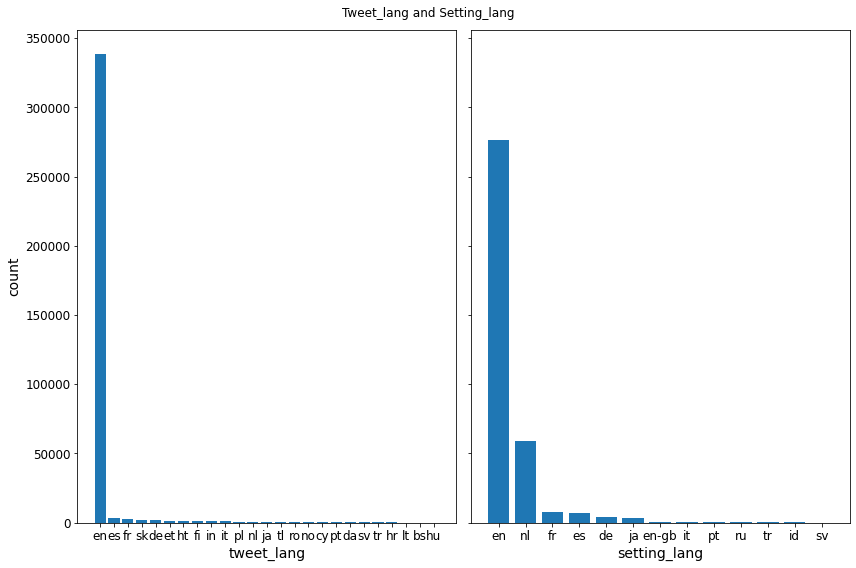

In [7]:
# 推文语言和推特界面语言
fig, axes = plt.subplots(1, 2, figsize=(12,8),sharey=True)
fig.suptitle('Tweet_lang and Setting_lang')
tweet_lang_count = df['tweet_lang'].value_counts()
tweet_lang_count = tweet_lang_count[tweet_lang_count > 100]
axes[0].bar(tweet_lang_count.index, tweet_lang_count.values)
axes[0].set_xlabel('tweet_lang')
axes[0].set_ylabel('count')

lang_count = df['lang'].value_counts()
lang_count = lang_count[lang_count > 100]
axes[1].bar(lang_count.index, lang_count.values)
axes[1].set_xlabel('setting_lang')

plt.tight_layout()
plt.show()

en - 英语 (English), 广泛使用于多个国家和地区。
nl - 荷兰语 (Dutch), 荷兰、比利时部分地区。
fr - 法语 (French), 法国、比利时、瑞士、加拿大部分地区等。
es - 西班牙语 (Spanish), 西班牙、拉丁美洲大部分国家。
de - 德语 (German), 德国、奥地利、瑞士部分地区等。
ja - 日语 (Japanese), 日本。
it - 意大利语 (Italian), 意大利。
pt - 葡萄牙语 (Portuguese), 葡萄牙、巴西。
tr - 土耳其语 (Turkish), 土耳其。
ru - 俄语 (Russian), 俄罗斯。
id - 印度尼西亚语 (Indonesian), 印度尼西亚。
en-gb / en-GB - 英国英语 (British English), 英国。
sv - 瑞典语 (Swedish), 瑞典。
pl - 波兰语 (Polish), 波兰。
no - 挪威语 (Norwegian), 挪威。
fi - 芬兰语 (Finnish), 芬兰。
hu - 匈牙利语 (Hungarian), 匈牙利。
cs - 捷克语 (Czech), 捷克共和国。
ca - 加泰罗尼亚语 (Catalan), 西班牙加泰罗尼亚地区。
eu - 巴斯克语 (Basque), 西班牙和法国的巴斯克地区。
zh-tw - 繁体中文 (Traditional Chinese), 主要在台湾、香港使用。
zh-Hans - 简体中文 (Simplified Chinese), 中国大陆。
ar - 阿拉伯语 (Arabic), 多个阿拉伯国家和地区。
da - 丹麦语 (Danish), 丹麦。
uk - 乌克兰语 (Ukrainian), 乌克兰。
ko - 韩语 (Korean), 韩国。
gl - 加利西亚语 (Galician), 西班牙加利西亚地区。
xx-lc - 不是标准的语言代码，可能是某个特定系统或数据集的特定标识。

**结论1：**
数据集以美国、荷兰、中国用户为主，推文主要使用英语

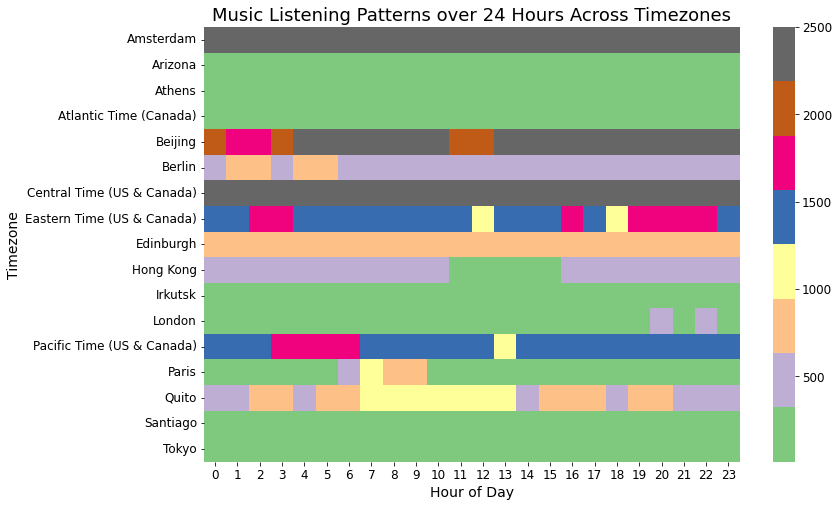

In [8]:
# 热图：几大时区在一天中24小时的听歌分布
import seaborn as sns
import pytz
from datetime import datetime

# 获取小时
df['hours'] = pd.to_datetime(df['created_at']).dt.hour

# 确保hours列涵盖0到23所有小时
hours = np.arange(24)

# 对time_zone和hours进行分组计数，然后重塑数据格式
result = (
    df.groupby(['time_zone', 'hours'])
    .size()
    .unstack(fill_value=0)  # 将hours变成列，缺失值填充0
    .reindex(columns=hours, fill_value=0)  # 确保所有小时都有，缺失的填充0
    .stack()  # 如果需要，可以将数据stack回长格式
    .reset_index(name='count')  # 重置索引，并给计数列命名为'count'
)
result = result[result['time_zone'].isin(time_zone_view.index)]
reshape_result = result.pivot(index='hours', columns='time_zone', values='count')
reshape_result = reshape_result.transpose()

# 绘制热图
sns.heatmap(reshape_result, cmap='Accent', vmin=10, vmax=2500)
plt.title('Music Listening Patterns over 24 Hours Across Timezones')
plt.ylabel('Timezone')
plt.xlabel('Hour of Day')
plt.show()


**结论：** 有些时区一天内听歌分布得较均匀，如Amesterdam、Arizona、Athens等，Beijing在4-11点，13点到24点听歌人都比较多等等

      month                   time_zone  count
8         1                   Amsterdam   1253
9         1                     Arizona      2
11        1                      Athens     27
12        1      Atlantic Time (Canada)    155
17        1                     Beijing   3343
...     ...                         ...    ...
1417     12  Pacific Time (US & Canada)   2427
1419     12                       Paris    306
1423     12                       Quito    597
1427     12                    Santiago    240
1442     12                       Tokyo     97

[204 rows x 3 columns]


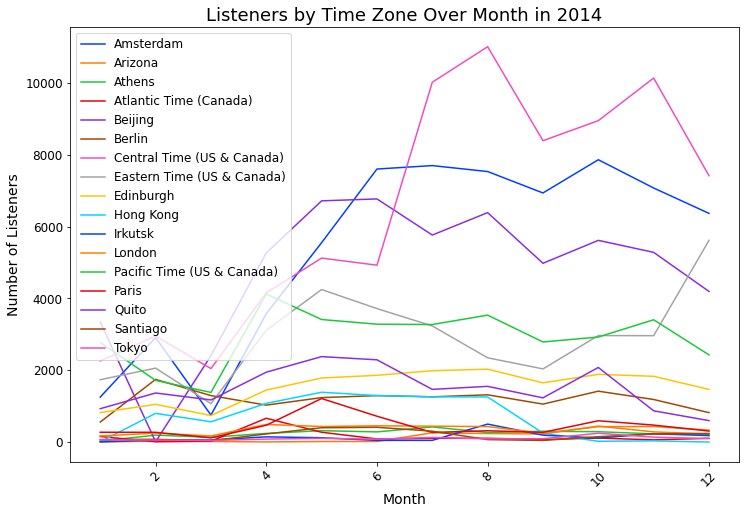

In [9]:
# 1月份-12月份听歌人数的变化

# 获取月份数据并转化成月、地区、数量的dataframe
df['month'] = pd.to_datetime(df['created_at']).dt.month
df['season'] = df['month'] // 3
data_group_by_month = df.groupby(by=['month', 'time_zone']).size().unstack(fill_value=0).stack().reset_index(name='count')
data_group_by_month = data_group_by_month[data_group_by_month['time_zone'].isin(time_zone_view.index)]
print(data_group_by_month)

# 使用seaborn绘制折线图
sns.lineplot(data=data_group_by_month, x='month', y='count', hue='time_zone', palette='bright')
plt.title('Listeners by Time Zone Over Month in 2014')
plt.ylabel('Number of Listeners')
plt.xlabel('Month')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

**结论：** 一年中1-3月听歌人数都比较少，4-11月有逐步增加的趋势，11-12月又减少

<Axes: ylabel='hashtag'>

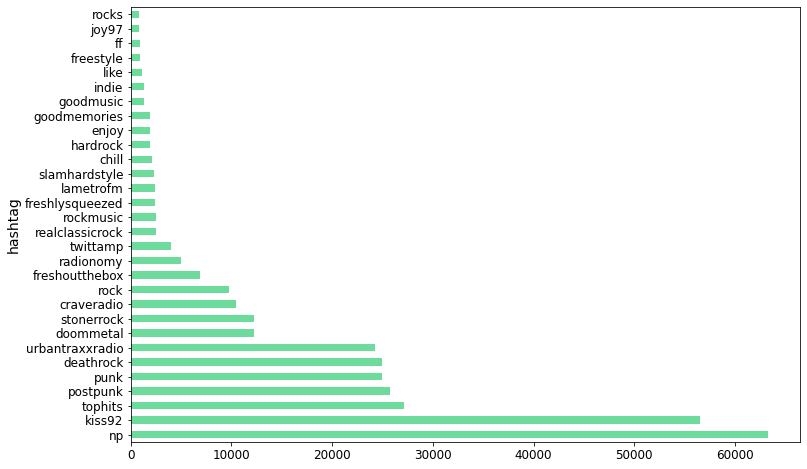

In [10]:
# valence 和 score（歌曲情感和用户使用的标签情绪评分）
hashtags = df['hashtag'].value_counts()
hashtags = hashtags[hashtags > 100][:30]
fig, axes = plt.subplots(1, 1)
hashtags.plot.barh(ax=axes, color='#2ecc71', alpha=0.7) # 翠绿

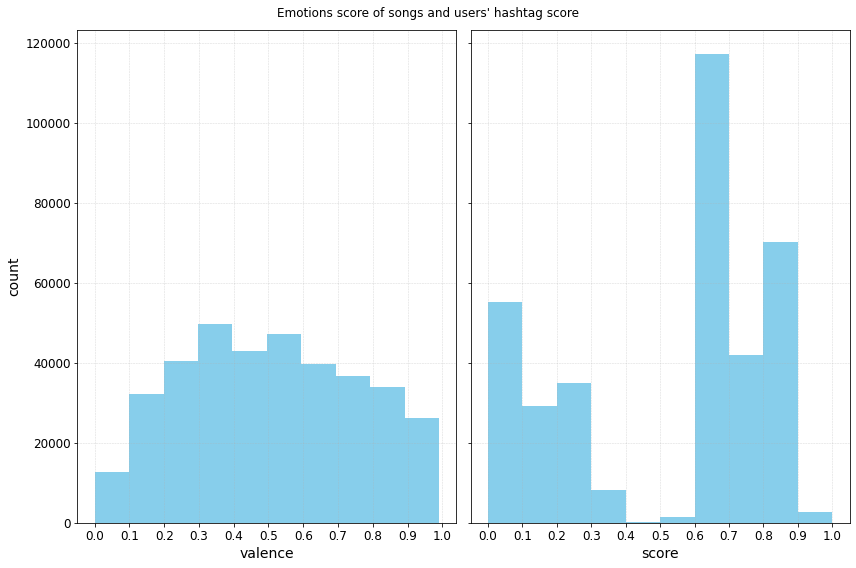

valence:(mean: 0.5076111400105168, std: 0.24883262086030813)
score:(mean: 0.526364220028437, std: 0.30250743274431285)


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
fig.suptitle("Emotions score of songs and users' hashtag score")

# 直方图和KDE曲线
axes[0].hist(df['valence'],color='skyblue')
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0].set_xlabel('valence')
axes[0].set_ylabel('count')

axes[1].hist(df['score'],color='skyblue')
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xlabel('score')

axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()
print(f"valence:(mean: {df['valence'].mean()}, std: {df['valence'].std()})")
print(f"score:(mean: {df['score'].mean()}, std: {df['score'].std()})")

**结论2：** 歌曲的情感几乎呈正态分布，用户情绪得分主要分布在两侧（0-0.4，0.6-1.0）即偏向于negtive或positive，在平静（neutral）时很少听音乐

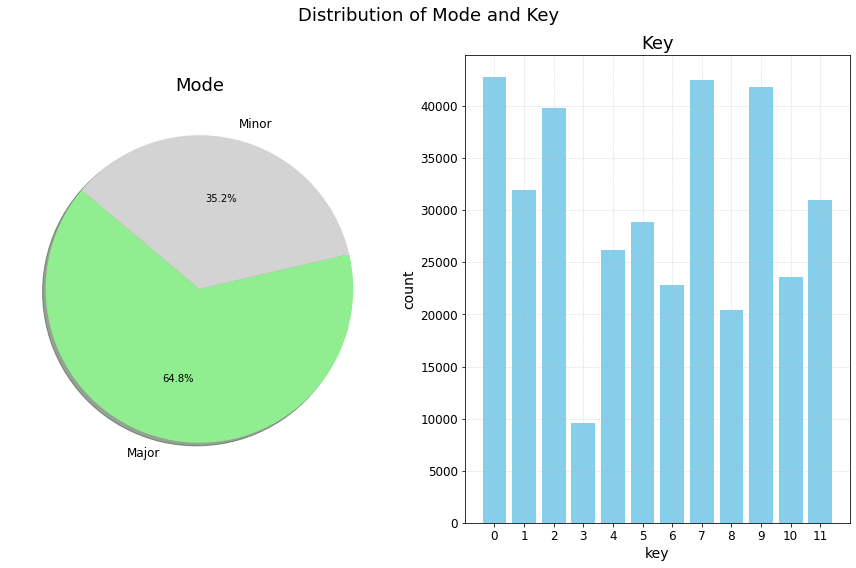

In [12]:
# 调式和音调
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Mode and Key', fontsize=18)

# 条形图
modes = df['mode'].value_counts()
keys = df['key'].value_counts()

axes[0].set_title('Mode')
axes[0].pie(modes.values, labels=['Major', 'Minor'], colors=['lightgreen', 'lightgray'], autopct='%1.1f%%', shadow=True, startangle=140)

axes[1].bar(keys.index, keys.values, color='skyblue')
axes[1].set_title('Key')
axes[1].set_xlabel('key')
axes[1].set_ylabel('count')
axes[1].set_xticks([i for i in range(0, 12)])

axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

0: C
1: C# / Db
2: D
3: D# / Eb
4: E
5: F
6: F# / Gb
7: G
8: G# / Ab
9: A
10: A# / Bb
11: B

**结论3：** 用户收听的音乐以大调歌曲为主，且各调式中，以C、D、E、F、G、A、B居多，升调#降调b相对少

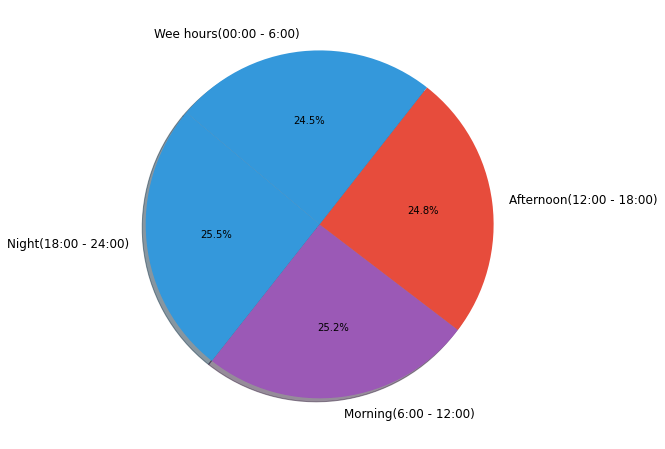

In [13]:
from datetime import datetime

created_time = df['created_at']
created_time = pd.to_datetime(created_time)

# 定义一个函数，根据时间判断属于早、中、晚哪个时段
def classify_time_period(time):
    if time.hour < 6:
        return 'Wee hours(00:00 - 6:00)'
    elif time.hour < 12:
        return 'Morning(6:00 - 12:00)'
    elif time.hour < 18:
        return 'Afternoon(12:00 - 18:00)'
    else:
        return 'Night(18:00 - 24:00)'

# 应用函数，创建一个新列来存储时段分类
period = created_time.apply(lambda x: classify_time_period(x))
df['day_time'] = period

period = period.value_counts()

fig, axes = plt.subplots(1, 1)
axes.pie(period.values, labels=period.index, autopct='%1.1f%%', shadow=True, startangle=140, colors=['#3498db', '#9b59b6', '#e74c3c'])
ax.set_ylabel('')
plt.show()

**结论4：** 听歌时间主要集中在0-12点（problem: 是哪个时区的时间？）

#### 双变量分析
* valence/score

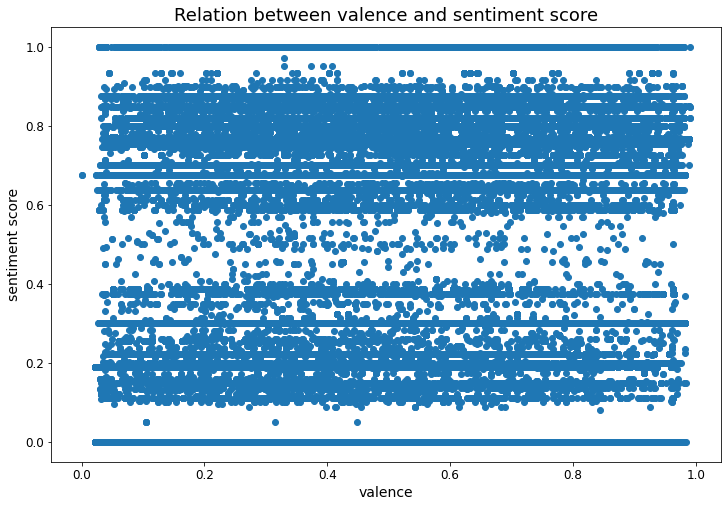

In [14]:
# valence and score
plt.scatter(df['valence'], df['score'])
plt.xlabel('valence')
plt.ylabel('sentiment score')
plt.title('Relation between valence and sentiment score')
plt.show()

In [15]:
# # 使用plt.hexbin来绘制六边形箱图
# plt.hexbin(df['valence'], df['score'], gridsize=30, cmap='Accent', mincnt=1)
# cb = plt.colorbar(label='count in bin')
# plt.xlabel('Valence')
# plt.ylabel('Score')
# plt.title('Hexbin plot of valence and sentiment score')
# plt.show()

In [16]:
# # 使用scipy.stats的gaussian_kde进行核密度估计
# from scipy.stats import gaussian_kde

# # 创建一个二维核密度估计
# kde = gaussian_kde([df['valence'], df['score']])

# # 创建一个网格来评估kde
# valence_grid, score_grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# kde_values = kde(np.vstack([valence_grid.ravel(), score_grid.ravel()]))

# # 绘制等高线图
# plt.contourf(valence_grid, score_grid, kde_values.reshape(valence_grid.shape), levels=10, cmap='viridis')
# plt.colorbar(label='Density')
# plt.title('Contour plot of valence and score')
# plt.xlabel('Valence')
# plt.ylabel('Score')
# plt.show()

In [17]:
# 计算Pearson相关系数和spearmanr相关系数
from scipy.stats import spearmanr

pearson_correlation_coefficient = np.corrcoef(df['valence'], df['score'])[0, 1]
print(f'pearson相关系数：{pearson_correlation_coefficient}')
# 计算Spearman相关系数
spearman_correlation_coefficient, p_value = spearmanr(df['valence'], df['score'])
print(f'spearman相关系数：{spearman_correlation_coefficient}')

pearson相关系数：0.14978302159881893
spearman相关系数：0.13502158062716219


**Pearson相关系数**：Pearson相关系数衡量的是两个连续变量之间的线性关系的强度和方向。

**Spearman相关系数**：Spearman相关系数衡量的是两个变量之间的单调关系的强度。

**结论5：** valence和sentiment score存在很弱的正相关性

#### 多变量分析

* 散点图矩阵分析（score与、Instrumentalness、livenes、speechiness等内容特征之间的关系）

In [18]:
df.describe()

,user_id,score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,hours,month,season
count,3.613460e+05,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000,361346.000000
mean,7.149575e+08,0.526364,0.140614,0.187013,0.067894,0.556895,0.507611,-7.875063,122.826798,0.150110,0.705937,0.647548,5.369164,11.593083,7.275954,2.077397
std,6.511049e+08,0.302507,0.272438,0.156104,0.065264,0.174811,0.248833,3.473346,27.606710,0.224976,0.194120,0.477734,3.608155,6.930243,3.075533,1.091827
min,2.129130e+05,0.000000,0.000000,0.013600,0.021800,0.062200,0.000010,-60.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.394018e+08,0.221875,0.000000,0.091100,0.034300,0.436000,0.308000,-9.779000,101.937000,0.003470,0.576250,0.000000,2.000000,6.000000,5.000000,1.000000
50%,5.440885e+08,0.675000,0.000357,0.127000,0.045200,0.570000,0.502000,-7.248000,121.874000,0.038700,0.735000,1.000000,6.000000,12.000000,7.000000,2.000000
75%,8.232143e+08,0.766667,0.090275,0.243000,0.071100,0.684000,0.711000,-5.328000,138.783000,0.194000,0.864000,1.000000,9.000000,18.000000,10.000000,3.000000
max,2.933948e+09,1.000000,0.999000,0.993000,0.950000,0.982000,0.991000,-0.117000,240.056000,0.996000,0.999000,1.000000,11.000000,23.000000,12.000000,4.000000


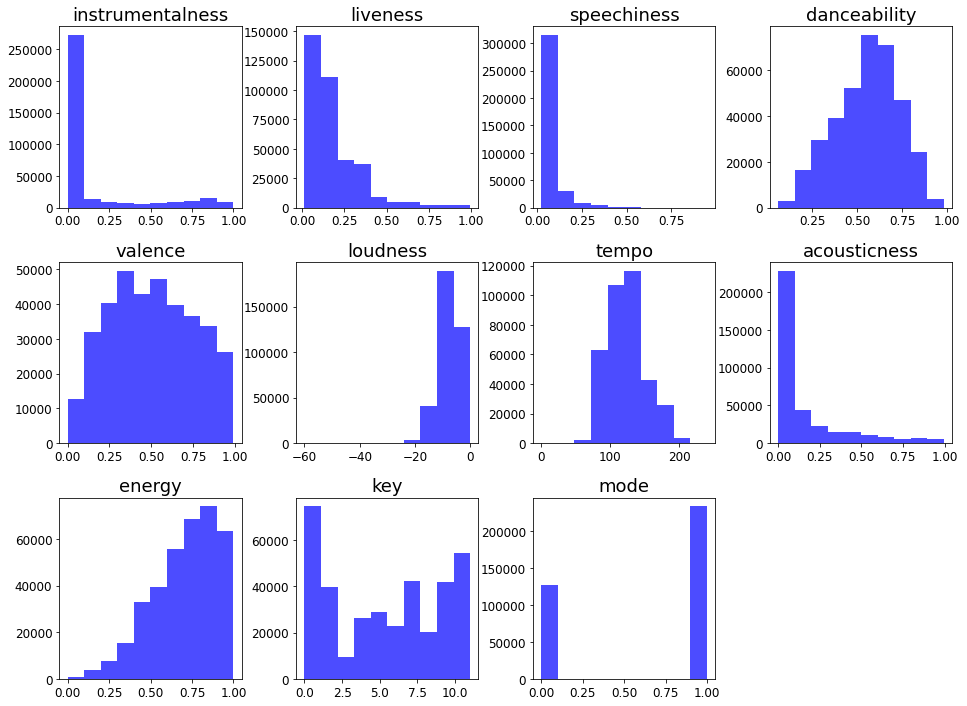

In [19]:
import matplotlib.pyplot as plt
# 对音频内容特征绘制直方图查看分布
columns = ['instrumentalness', 'liveness', 'speechiness', 
           'danceability', 'valence', 'loudness', 'tempo', 
           'acousticness', 'energy', 'key', 'mode']
df.hist(column=columns, bins=10, grid=False, figsize=(16, 12), color='blue', alpha=0.7, layout=(3, 4))

# 显示图形
plt.show()

In [20]:
# 去除一些可能的噪音
df = df[df['tempo'] >= 20]
df = df[df['tempo'] <= 200]
df = df[df['energy'] >= 0.2]
df = df[df['loudness'] >= -20]
df

,user_id,track_id,hashtag,created_at,score,lang,tweet_lang,time_zone,instrumentalness,liveness,...,loudness,tempo,acousticness,energy,mode,key,hours,month,season,day_time
0,823214346,b129f3e0a0bdc1e61c57ce994f9d2932,kiss92,2014-01-01 05:59:38,0.80,en,en,Beijing,0.000000,0.0764,...,-7.698,80.133,0.341000,0.408,1.0,8.0,5,1,0,Wee hours(00:00 - 6:00)
1,823214346,64b30f6ac1acecb7cef9dc890e1c3ea7,kiss92,2014-01-01 06:06:15,0.80,en,en,Beijing,0.018300,0.1090,...,-6.440,127.955,0.000357,0.759,1.0,9.0,6,1,0,Morning(6:00 - 12:00)
2,823214346,cc1a46ee0446538ecf6b65db01c30cd8,kiss92,2014-01-01 06:11:07,0.80,en,en,Beijing,0.000000,0.0931,...,-4.197,92.526,0.077000,0.846,1.0,4.0,6,1,0,Morning(6:00 - 12:00)
3,823214346,dbbd8525c1bc48cc791bfe618b74bac6,kiss92,2014-01-01 06:19:43,0.80,en,en,Beijing,0.000000,0.0909,...,-4.217,122.010,0.032700,0.934,1.0,3.0,6,1,0,Morning(6:00 - 12:00)
4,823214346,dbdbb866939c1ab1dfd0d5cfac740eaa,kiss92,2014-01-01 06:23:47,0.80,en,en,Beijing,0.000005,0.0951,...,-5.581,99.252,0.081800,0.923,1.0,0.0,6,1,0,Morning(6:00 - 12:00)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104329,1549216658,fbfd4b6ff80084a38f596257089009fc,ripjoecocker,2014-12-22 23:31:40,0.15,en,en,London,0.000143,0.3200,...,-12.976,117.969,0.021400,0.674,0.0,9.0,23,12,4,Night(18:00 - 24:00)
104330,33679225,ca6e67e4f5840c389c426f8e11a99dec,hotchip,2014-12-23 00:39:26,1.00,en,en,Pacific Time (US & Canada),0.000106,0.0757,...,-8.192,136.996,0.597000,0.387,0.0,8.0,0,12,4,Wee hours(00:00 - 6:00)
104331,186008229,c4a0c3feae47b6e6a09141483782302f,confused,2014-12-23 03:49:11,0.30,en,en,Alaska,0.001010,0.2330,...,-7.519,95.982,0.263000,0.609,0.0,11.0,3,12,4,Wee hours(00:00 - 6:00)
104332,223620983,2fd9f021f0a9336ef8c2585740491d21,bummer,2014-12-23 04:50:24,0.30,en,en,Mountain Time (US & Canada),0.091000,0.2830,...,-10.031,90.095,0.674000,0.836,1.0,0.0,4,12,4,Wee hours(00:00 - 6:00)


In [21]:
import seaborn as sns
from scipy import stats
from matplotlib.patches import Circle

# 需要归一化的列
columns = ['loudness', 'tempo']
for column in columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column]. min())
df.describe()

,user_id,score,instrumentalness,liveness,speechiness,danceability,valence,loudness,tempo,acousticness,energy,mode,key,hours,month,season
count,3.546670e+05,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000,354667.000000
mean,7.154943e+08,0.526288,0.140143,0.187278,0.067717,0.559296,0.510321,0.614055,0.529018,0.142453,0.713213,0.646832,5.373607,11.590261,7.272258,2.075970
std,6.509685e+08,0.302417,0.271671,0.156197,0.064327,0.174263,0.247769,0.163124,0.163305,0.214459,0.184284,0.477955,3.610619,6.928368,3.074282,1.091272
min,2.129130e+05,0.000000,0.000000,0.013600,0.021800,0.064800,0.021100,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.566884e+08,0.221875,0.000000,0.091000,0.034200,0.441000,0.314000,0.517898,0.403819,0.003360,0.586000,0.000000,2.000000,6.000000,5.000000,1.000000
50%,5.440885e+08,0.675000,0.000356,0.127000,0.045400,0.573000,0.505000,0.641132,0.523211,0.037600,0.739000,1.000000,6.000000,12.000000,7.000000,2.000000
75%,8.232143e+08,0.766667,0.089500,0.244000,0.071400,0.686000,0.713000,0.737684,0.624040,0.183000,0.866000,1.000000,9.000000,18.000000,10.000000,3.000000
max,2.933948e+09,1.000000,0.998000,0.993000,0.950000,0.982000,0.991000,1.000000,1.000000,0.995000,0.999000,1.000000,11.000000,23.000000,12.000000,4.000000


In [22]:
# # 进行相关性分析的列
# columns = ['score', 'valence', 'instrumentalness', 'speechiness', 'acousticness', 
#            'liveness', 'danceability', 'loudness', 'tempo', 'energy']

# # 初始化PairGrid
# g = sns.PairGrid(df[columns])

# # 对角线上绘制核密度分布，反映其分布特性
# g.map_diag(sns.kdeplot)

# # 下三角绘制散点图
# g.map_lower(sns.scatterplot)

# # 上三角显示相关系数
# def corrfunc(x, y, **kwargs):
#     r, _ = stats.pearsonr(x, y)
#     facecolor = sns.diverging_palette(240, 10, n=9, as_cmap=True)(0.5*(r+1))
#     ax = plt.gca()
#     ax.add_patch(plt.Circle((0.5, 0.5), transform=ax.transAxes, facecolor=facecolor, edgecolor='none'))
#     ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords=ax.transAxes, ha='center', va='center')

    
# g.map_upper(corrfunc)

# plt.show()

**结论6：** 各特征之间没有太强的相关性，其中vocal与情绪得分score、vocal与rhythm有弱的正相关，reality和rhythm有稍强的负相关。其他的特征诸如key、mode、rhythm、reality都与情绪分数score没有太大关联

### 回归分析
我们最关心的输入，应该是score，表征用户情绪，最关心的输出，应是valence，表征歌曲的情感倾向。这样就可以根据用户的情绪输入，来推荐一些相关的歌曲。但是这就导致其他音频特征liveness、tempo、energy等无法作为输入？因为我们没法在用户输入时直接获取到这些特征。能不能对每一个特征都和valence做一个回归看看呢？

In [23]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.metrics import mean_squared_error

# X = df['score'].values.reshape(-1, 1)
# y = df['valence'].values.reshape(-1, 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# models = [RandomForestRegressor(n_estimators=100, random_state=42), 
#           LinearRegression(),
#           Ridge(alpha=1.0),
#           Lasso(alpha=1.0)
#          ]

# for model in models:
#     model = model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     Rscore = model.score(X_test, y_test)
#     print(f'{model.__class__.__name__}: mse:{mse}, Rscore:{Rscore}')

**结论：** 几个回归模型的均方差和Rscore显示回归模型的效果并不好，Rscore接近0甚至负表示和直接预测valence为平均值差别不大甚至不如直接预测平均值

根据MSE和Rscore分数，可以看出这些回归模型在当前的任务上表现都不是很理想。尽管随机森林回归器在预测准确性上略胜一筹，但所有模型在解释目标变量的变异性上都做得不好。
这可能意味着：
数据之间的关系可能并不是线性的，或者存在复杂的非线性模式，这对于线性模型来说是个挑战。

特征和目标之间可能存在噪声或其他未观测到的变量影响，导致模型难以捕捉到它们之间的关系。

模型的复杂度可能不足以捕捉数据中存在的模式，或者数据不足以训练更复杂的模型。

### 聚类分析
先根据音频特征将音乐聚为N类，再试图联合score、语言、时间、地点做一个上下文的推荐呢？结果如何

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# int 型 one-hot 编码，
df['mode'] = df['mode'].astype(int)
df['key'] = df['key'].astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354667 entries, 0 to 104333
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           354667 non-null  int64  
 1   track_id          354667 non-null  object 
 2   hashtag           354667 non-null  object 
 3   created_at        354667 non-null  object 
 4   score             354667 non-null  float64
 5   lang              354667 non-null  object 
 6   tweet_lang        354667 non-null  object 
 7   time_zone         354667 non-null  object 
 8   instrumentalness  354667 non-null  float64
 9   liveness          354667 non-null  float64
 10  speechiness       354667 non-null  float64
 11  danceability      354667 non-null  float64
 12  valence           354667 non-null  float64
 13  loudness          354667 non-null  float64
 14  tempo             354667 non-null  float64
 15  acousticness      354667 non-null  float64
 16  energy            354667 

In [26]:
# 获得聚类数据
# 聚类使用
cluster_columns = ['instrumentalness', 'liveness', 'speechiness', 
                   'danceability', 'valence', 'loudness', 'tempo', 'acousticness', 'energy',
                   'mode', 'key', 'track_id']
df_cluster =  df[cluster_columns]
df_cluster.info()

df_cluster.to_csv('./cluster_data.csv', index = False)

# 分类及回归使用
classify_columns = ['score', 'hashtag', 'lang', 'tweet_lang', 'time_zone' ,
                    'created_at', 'season', 'month', 'day_time','hours',
                    'track_id', 'valence']
df_classify = df[classify_columns]
df_classify.to_csv('./classify_data.csv', index = False)
print(df_classify.info())

<class 'pandas.core.frame.DataFrame'>
Index: 354667 entries, 0 to 104333
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   instrumentalness  354667 non-null  float64
 1   liveness          354667 non-null  float64
 2   speechiness       354667 non-null  float64
 3   danceability      354667 non-null  float64
 4   valence           354667 non-null  float64
 5   loudness          354667 non-null  float64
 6   tempo             354667 non-null  float64
 7   acousticness      354667 non-null  float64
 8   energy            354667 non-null  float64
 9   mode              354667 non-null  int64  
 10  key               354667 non-null  int64  
 11  track_id          354667 non-null  object 
dtypes: float64(9), int64(2), object(1)
memory usage: 35.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 354667 entries, 0 to 104333
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------